In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import py21cmfast as p21c
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
# read some test cubes
#lightcone = p21c.outputs.LightCone.read("./Lightcones/LightCone_z4.0.h5")
#coeval5 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z5.0.h5")
#coeval6 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z6.0.h5")
#oeval7 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z7.0.h5")
#coeval8 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z8.0.h5")
#coeval10 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z10.0.h5")
#oeval12 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z12.0.h5")
#coeval15 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z15.0.h5")
#coeval20 = p21c.outputs.Coeval.read("./Lightcones/Coeval_z20.0.h5")

lc = '../data/res_comp/temp.npz' # BOX_LEN = 200 , DIM = 140
#lc_mock = './Lightcones/opt_mock/run999.npz'
#lc_3 = './Lightcones/pure_simulations/run795.npz'


#gxH_redshifts = np.load('./Lightcones/redshifts5.npy')

In [20]:
# reading the LCs and computing the redshifts
def read_image(files):
    cone = np.load(files)
    image = cone['image']
    return image

def read_gxH(files):
    cone = np.load(files)
    gxH = cone['gxH']
    return gxH

def compute_redshifts(files,return_Ts=True):
    cone = np.load(files)
    image = cone['image']
    label = cone['label']
    redshift = cone['z']


    return redshift

def compute_cosmo(files,return_Ts=True):
    cone = np.load(files)
    label = cone['label']
    cosmo_params = p21c.CosmoParams(OMm=label[1])
    hlittle = cosmo_params.hlittle
    OMm = cosmo_params.OMm
    return hlittle, OMm

def compute_user_params(files,return_Ts=True):
    cone = np.load(files)
    image = cone['image']
    label = cone['label']
    
    cosmo_params = p21c.CosmoParams(OMm=label[1])
    astro_params = p21c.AstroParams(INHOMO_RECO=True)
    user_params = p21c.UserParams(HII_DIM=140, BOX_LEN=200)
    flag_options = p21c.FlagOptions()
    sim_lightcone=p21c.LightCone(5.,user_params,cosmo_params,astro_params,flag_options,0,{"brightness_temp":image},35.05)
    user_params = sim_lightcone.user_params

    return user_params

In [21]:
# instrument settings
deg2_instrument = 100.0 # SKA deep total size 
basemax_instrument = 10**5 # max. baseline for SKA in cm
beamsize_instrument = 10**-1 # check for SKA!!
nu_res = 3.9*10**3 # in Hz, for SKA1-Low

# I still need to check these value!

In [22]:
# some functions instrumental constraints 

# redshifted 21cm line 
def l21(z):
    lam21= 21.1061 # in cm
    return lam21*(1+z)

# convert wavelength in cm to frequency in Hz
def ltonu(l):
    c_cm = 3*10**10
    return c_cm/l

# convert from deg2 to Mpc
def deg2_to_Mpc(Adeg2, file, z):
    cosmo = FlatLambdaCDM(H0=compute_cosmo(file)[0]*100, Om0=compute_cosmo(file)[1])
    # angular diameter distance in Mpc
    d_A = cosmo.angular_diameter_distance(z=z)
    theta_radian = np.sqrt(Adeg2) * np.pi / 180 
    distance_Mpc = d_A * theta_radian
    return distance_Mpc.to_value()

# compute slope of the foreground wedge 
def f_wedge(file, z, theta):
    cosmo = FlatLambdaCDM(H0=compute_cosmo(file)[0]*100, Om0=compute_cosmo(file)[1])
    factor = cosmo.comoving_distance(z) * cosmo.H(z) * theta / (1+z) / c.to('km/s')
    return factor.value

# compute maximum k_perp due to telescope baseline
def k_perp_res(file, z):
    cosmo = FlatLambdaCDM(H0=compute_cosmo(file)[0]*100, Om0=compute_cosmo(file)[1])
    comoving_distance = cosmo.comoving_distance(z).value
    basemax = basemax_instrument #max baseline in cm 
    sizepix = l21(z)/basemax*180/np.pi/60 # angular resolution interferometer in arcmin

    return (1/comoving_distance/(sizepix/60*np.pi/180))

# compute maximum k_par due to line of sight resolution
def k_par_res(file, z):
    cosmo = FlatLambdaCDM(H0=compute_cosmo(file)[0]*100, Om0=compute_cosmo(file)[1])
    nu_obs = ltonu(l21(z))
    freq_res = nu_obs/nu_res # frequency resolution
    return (cosmo.H(z) / (c.to('km/s')*(1+z))).value * freq_res

# compute min k_par from redshift resolution
def k_par_min(file, z1, z2):
    cosmo = FlatLambdaCDM(H0=compute_cosmo(file)[0]*100, Om0=compute_cosmo(file)[1])
    comoving_distance = cosmo.comoving_distance(z2).value - cosmo.comoving_distance(z1).value
    k = 2*np.pi / comoving_distance
    return k


In [23]:
# computing the 2D PS for LC chunks
def compute_2D_PS_chunk(file, start, end, BOX_LEN, DIM, z, k_factor, use_wedge):

    # compute the instrumental constaints, yields the max. and min. observable k-scales
    if use_wedge:
        k_wedge = f_wedge(file=file, z=z, theta=beamsize_instrument) 
    else:
        k_wedge = 0
    k_perp_min = 2*np.pi/deg2_to_Mpc(Adeg2=deg2_instrument, file=file, z=z) 
    k_par_max = k_par_res(file, z)
    k_perp_max = k_perp_res(file, z)


    # read image from LC file
    field = read_image(file)[:, :, start:end]

    # compute dimensions of the LC chunk of interest
    cell_size = BOX_LEN/DIM 
    print('resolution is:', np.round(cell_size, 2))
    chunklen = (end - start) * cell_size # the physical chuncklength in MPc
    print('physical chunklen:', np.round(chunklen, 2))

    # factor for Fourier convention
    d_cell = cell_size/2/np.pi
    DIM_MIDDLE = int(DIM/2+1)
    # consider that z might have different dimension
    DIM_z = int(chunklen / cell_size)
    DIM_MIDDLE_z = int(DIM_z/2+1)

    # compute Fourier frequencies for (x,y) and z respectively
    kbox = np.fft.rfftfreq(int(DIM), d=d_cell)
    kbox_z = np.fft.rfftfreq(int(DIM_z), d=d_cell)

    # k_factor determines the binning
    k_factor = k_factor

    V= BOX_LEN**2 * chunklen # Volume in Mpc**3 to normalise PS
    DELTA_K = kbox[1]
    DELTA_K_z = kbox_z[1]
    k_first_bin_ceil = DELTA_K
    k_first_bin_ceil_z = DELTA_K_z
    k_max=kbox[-1]
    k_max_z = kbox_z[-1]
    #k_max=DELTA_K*DIM # kbox[-1] # kbox[-1] is max available, or DELTA_K*DIM

    # compute number of bins for (x,y)
    NUM_BINS = 0
    k_floor = 0.0
    k_ceil = k_first_bin_ceil
    while (k_ceil < k_max):
        NUM_BINS += 1
        k_floor=k_ceil
        k_ceil = k_ceil*k_factor
        
    print('NUM_BINS count', NUM_BINS)

    # compute number of bins for z
    NUM_BINS_z = 0
    k_floor_z = 0.0
    k_ceil_z = k_first_bin_ceil_z
    while (k_ceil_z < k_max_z):
        NUM_BINS_z += 1
        k_floor_z=k_ceil_z
        k_ceil_z = k_ceil_z*k_factor
        
    print('NUM_BINS_z count', NUM_BINS_z)
    

    # initialise 2D PS  
    in_bin_ct = [0 for i in range(NUM_BINS)]
    in_bin_ct_perp = [0 for i in range(NUM_BINS)]
    in_bin_ct_par = [0 for i in range(NUM_BINS_z)]
    p_box = np.zeros((NUM_BINS_z, NUM_BINS))
    #p_noise = [0 for i in range(NUM_BINS)]
    k_ave = [0 for i in range(NUM_BINS)]
    k_perp_ave = [0 for i in range(NUM_BINS)]
    k_par_ave = [0 for i in range(NUM_BINS_z)]  

    # scale field
    field_scaled = field * cell_size**3
    # fourier transform of field
    deldel_field = np.fft.rfftn(field_scaled) 
    field_amplitudes = np.abs(deldel_field)**2 

# loop to construct 2D PS
    # loop over (x,y) and z using their corresponding dimensions
    for n_x in range(DIM):
        if (n_x>DIM_MIDDLE):
            k_x =(n_x-DIM) * DELTA_K 
        else:
            k_x = n_x * DELTA_K
        for n_y in range(DIM):
            if (n_y>DIM_MIDDLE):   
                k_y =(n_y-DIM) * DELTA_K
            else:
                k_y = n_y * DELTA_K                                         
            for n_z in range(DIM_MIDDLE_z):
                k_z = n_z * DELTA_K_z

                # in each cell we compute k_perp and k_par
                k_perp = np.sqrt(k_x*k_x + k_y*k_y)
                k_par = np.sqrt(k_z*k_z)
                k_mag = np.sqrt(k_perp*k_perp + k_par*k_par)
                k_floor = 0.0
                k_ceil = k_first_bin_ceil
                ct = 0
                ct_perp = 0
                ct_par = 0
                k_perp_ceil = k_first_bin_ceil
                k_par_ceil = k_first_bin_ceil_z
                k_par_floor = 0       # adjust here for min. k_par
                k_perp_floor = 0
                #k_perp_floor = k_perp_SKA             # adjust here for min. k_perp

                while k_ceil < k_max :
                    if ((k_mag >= k_floor) and (k_mag < k_ceil)) :
                        in_bin_ct[ct] += 1
                        
                        while k_perp_ceil < k_max :
                            
                            if ((k_perp>=k_perp_floor) and (k_perp < k_perp_ceil)) and (k_perp>k_perp_min) and (k_perp < k_perp_max):
                                in_bin_ct_perp[ct_perp] += 1
                    
                                while k_par_ceil < k_max_z :
                                    
                                    
                                    if ((k_par >= k_par_floor) and (k_par < k_par_ceil)) and (k_par < k_par_max) and (k_par > k_wedge * k_perp):
                                        in_bin_ct_par[ct_par] += 1
                                        p_box[ct_par][ct_perp] += np.array(pow(k_perp,2)*np.array(k_par)*field_amplitudes[n_x,n_y,n_z]/(2.0*np.pi**2*V))
                                        k_par_ave[ct_par] += k_par
                                    
                                        break
                                    
                                    ct_par+=1
                                    k_par_floor=k_par_ceil
                                    k_par_ceil=k_par_ceil*k_factor
                                
                                k_perp_ave[ct_perp] += k_perp
                                break

                            ct_perp+=1
                            k_perp_floor=k_perp_ceil
                            k_perp_ceil*=k_factor
                
                        k_ave[ct] += k_mag
                        break
                            
                    ct += 1
                    k_floor = k_ceil
                    k_ceil *= k_factor


    k_par_ave = np.array(k_par_ave)
    k_perp_ave = np.array(k_perp_ave)
    in_bin_ct_par = np.array(in_bin_ct_par)
    in_bin_ct_perp = np.array(in_bin_ct_perp)

    # Initialize p_box_norm array
    p_box_norm = np.zeros_like(p_box)
    k_perp_norm = np.zeros_like(k_perp_ave)
    k_par_norm = np.zeros_like(k_par_ave)

    # Compute p_box_norm
    for ct_par in range(NUM_BINS_z):
        for ct_perp in range(NUM_BINS):
            if k_par_ave[ct_par] != 0 and k_perp_ave[ct_perp] != 0 and in_bin_ct_par[ct_par] != 0 and in_bin_ct_perp[ct_perp] != 0:
                p_box_norm[ct_par][ct_perp] = p_box[ct_par][ct_perp] / (in_bin_ct_perp[ct_perp] + in_bin_ct_par[ct_par])
                k_perp_norm[ct_perp] = k_perp_ave[ct_perp] / in_bin_ct_perp[ct_perp] 
                k_par_norm[ct_par] = k_par_ave[ct_par] / in_bin_ct_par[ct_par] 

    return k_perp_norm, k_par_norm, p_box_norm

In [24]:
# computes 2D PS for a redshift chunk determined by z1 and z2, the default BOX_LEN is according to our standard LCs
def compute_2D_PS(file, z, dz, BOX_LEN=200, k_factor=1.5, use_wedge=False): # here file is .npz LC file
    field = read_image(file)
    DIM = field.shape[0]
    lc_redshifts = compute_redshifts(file)
    # Get indices that correspond to redshift range
    z1 = z-dz/2
    z2 = z+dz/2
    start = np.searchsorted(lc_redshifts, z1, side='left') 
    end = (np.searchsorted(lc_redshifts, z2, side='right') - 1 ) 
    # return power and compute mean redshift
    z_mean = np.mean(lc_redshifts[start:end])
    
    # computing the PS
    k_perp, k_par, power = compute_2D_PS_chunk(file, start=start, end=end, BOX_LEN=BOX_LEN, DIM=DIM, z=z_mean, k_factor=k_factor, use_wedge=use_wedge)
    print('Mean redshift:', np.round(z_mean, 2))
    print('-----------------------------') 
    return k_perp, k_par, power, z, dz

In [37]:
def plot_2D_PS(PS, file, use_wedge=False, use_k_min=False):
    from matplotlib.colors import LogNorm
    k_perp, k_par, power = PS[0], PS[1], PS[2]
    z, dz = PS[3], PS[4]
    # Create 2D plot (contour plot)
    #K_PERP, K_PAR = np.meshgrid(k_perp, k_par)
    K_PERP, K_PAR = k_perp, k_par
    mesh = plt.pcolor(K_PERP, K_PAR, power, cmap='magma', shading='auto') #vmin=0, vmax=2) #norm=LogNorm(vmin=0.01, vmax=100.))  
    colorbar = plt.colorbar(mesh, label=r'$\Delta^2(k_\perp, k_\parallel)\left[\mathrm{mK^2}\right]$')
    #colorbar.set_clim(0, 2)
    #colorbar.set_ticklabels([0, 1, 2])

    if use_wedge:
        wedge = f_wedge(file=file, z=z, theta=beamsize_instrument) * k_perp
        plt.plot(k_perp, wedge, color='black', linestyle='--')
    if use_k_min:
        x = np.linspace(0,100,10)
        k = k_par_min(file=file, z1=z-dz, z2=z+dz)
        y = np.full_like(x, fill_value=k)
        plt.plot(x,y, color='black', linestyle='--')
        


    # Label axes
    plt.xlabel(r'$k_\perp \left[\mathrm{Mpc}^{-1}\right]$')
    plt.ylabel(r'$k_\parallel \left[\mathrm{Mpc}^{-1}\right]$')
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim(0.05, 2.5)
    #plt.ylim(0.05, 2.5)
    #plt.minorticks_off()
    plt.title(f'21cm power spectrum for redshift range z = {np.round(z-dz/2, 2),np.round(z+dz/2, 2)}')
    plt.grid(True)

    plt.show()

In [42]:
PS = compute_2D_PS(lc, z=8, dz=0.5, k_factor=1.1, use_wedge=False)

resolution is: 1.82
physical chunklen: 145.45
NUM_BINS count 43
NUM_BINS_z count 39
Mean redshift: 7.99
-----------------------------


/tmp/ipykernel_16401/3871838299.py:8: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  mesh = plt.pcolor(K_PERP, K_PAR, power, cmap='magma', shading='auto') #vmin=0, vmax=2) #norm=LogNorm(vmin=0.01, vmax=100.))


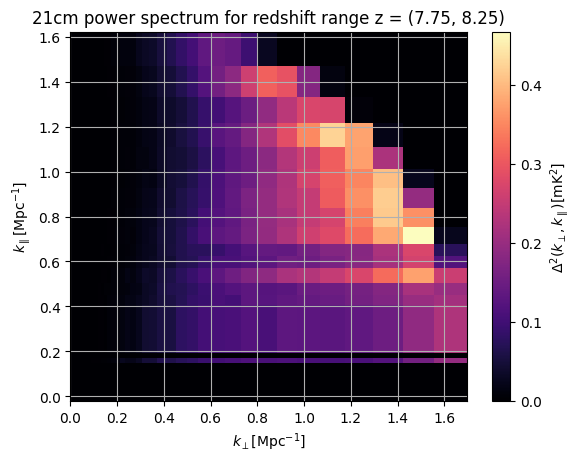

In [43]:
plot_2D_PS(PS, lc)

In [44]:
PS

(array([0.        , 0.        , 0.        , 0.        , 0.04442883,
        0.        , 0.        , 0.        , 0.06283185, 0.07024815,
        0.        , 0.08885766, 0.09424778, 0.09934588, 0.11327173,
        0.12824202, 0.13809303, 0.15707963, 0.16468518, 0.18579527,
        0.2035321 , 0.22460671, 0.24818958, 0.26933539, 0.29368645,
        0.32515738, 0.35626088, 0.39289392, 0.43418067, 0.47703508,
        0.52275043, 0.57464073, 0.63341785, 0.6972777 , 0.76663842,
        0.84310061, 0.92660746, 1.01924709, 1.1213894 , 1.23418701,
        1.35675435, 1.49096513, 1.62831537]),
 array([0.        , 0.0431969 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.0863938 , 0.        ,
        0.        , 0.        , 0.1295907 , 0.        , 0.        ,
        0.1727876 , 0.        , 0.21598449, 0.        , 0.25918139,
        0.        , 0.30237829, 0.34557519, 0.        , 0.38877209,
        0.43196899, 0.47516589, 0.53975263, 0.60475659, 0.64795348,
  

In [17]:
np.load(lc)['image']

array([[[  0.       ,   0.       ,   0.       , ...,  -8.179718 ,
          -9.301738 , -10.322307 ],
        [  0.       ,   0.       ,   0.       , ...,  -6.5021415,
          -9.0128565, -11.082773 ],
        [  0.       ,   0.       ,   0.       , ...,  -6.5527935,
          -9.675274 , -11.339447 ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  -9.072562 ,
          -9.568743 , -11.262471 ],
        [  0.       ,   0.       ,   0.       , ...,  -9.84502  ,
          -9.027181 , -11.071568 ],
        [  0.       ,   0.       ,   0.       , ...,  -9.678147 ,
          -9.493368 , -11.254738 ]],

       [[  0.       ,   0.       ,   0.       , ...,  -8.759306 ,
          -8.726964 , -10.177788 ],
        [  0.       ,   0.       ,   0.       , ...,  -6.696889 ,
          -7.7670712,  -9.845822 ],
        [  0.       ,   0.       ,   0.       , ...,  -6.252779 ,
          -7.7076573,  -9.629985 ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,  